# Weather Data Cleaning

# Introduction
This project is meant to gather insights on electricity usage.

This step is needed to clean up the raw weather data so, it's usable for correlation with the Energy Usage Data, visualizations and machine learning algorthms.

## Data Source
This data was collected using [Meteostat](https://github.com/meteostat/meteostat-python). The Meteostat Python library provides a simple API for accessing open weather and climate data. The historical observations and statistics are collected by Meteostat from different public interfaces, most of which are governmental.

Among the data sources are national weather services like the National Oceanic and Atmospheric Administration (NOAA) and Germany's national meteorological service (DWD).

# Goals
* become familiar with the dataset
* remove redundant data
* clean anomalous data

###  src: [Meteostat Documentation](https://dev.meteostat.net/python/hourly.html#data-structure)

| | | |
|-|-|-|
|**Column**|**Description**|**Type**|
|**station**|Meteostat ID of the weather station (only if query refers to multiple stations)|String|
|**time**|datetime of the observation|Datetime64|
|**temp**|air temperature in *°C*|Float64|
|**dwpt**|dew point in *°C*|Float64|
|**rhum**|relative humidity in percent (*%*)|Float64|
|**prcp**|one hour precipitation total in *mm*|Float64|
|**snow**|snow depth in *mm*|Float64|
|**wdir**|average wind direction in degrees (*°*)|Float64|
|**wspd**|average wind speed in *km/h*|Float64|
|**wpgt**|peak wind gust in *km/h*|Float64|
|**pres**|average sea-level air pressure in *hPa*|Float64|
|**tsun**|one hour sunshine total in minutes (*m*)|Float64|
|**coco**|[weather condition code](https://dev.meteostat.net/formats.html#weather-condition-codes) |Float64|

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Import the energy use spreadsheet from the 'data' directory

# Define the directory path and the regular expression pattern
import glob
directory_path = "./data"
file_pattern = "weather_*.csv"

# Use glob.glob to match filenames based on the pattern
file_path = glob.glob(f"{directory_path}/{file_pattern}")[0]
weather_df_raw = pd.read_csv(filepath_or_buffer=file_path)
weather_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    8785 non-null   object 
 1   temp    8785 non-null   float64
 2   dwpt    8785 non-null   float64
 3   rhum    8785 non-null   float64
 4   prcp    8785 non-null   float64
 5   snow    0 non-null      float64
 6   wdir    8785 non-null   float64
 7   wspd    8785 non-null   float64
 8   wpgt    0 non-null      float64
 9   pres    8785 non-null   float64
 10  tsun    0 non-null      float64
 11  coco    8785 non-null   float64
dtypes: float64(11), object(1)
memory usage: 823.7+ KB


In [4]:
weather_df_raw.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2022-10-21 00:00:00,13.0,1.1,44.0,0.0,NaN,190.0,7.6,NaN,1008.0,NaN,3.0
1,2022-10-21 01:00:00,10.7,1.0,51.0,0.0,NaN,160.0,7.6,NaN,1008.0,NaN,3.0
2,2022-10-21 02:00:00,9.0,1.5,59.0,0.0,NaN,180.0,5.4,NaN,1008.0,NaN,3.0
3,2022-10-21 03:00:00,9.0,1.5,59.0,0.0,NaN,180.0,5.4,NaN,1008.0,NaN,3.0
4,2022-10-21 04:00:00,7.6,1.5,65.0,0.0,NaN,170.0,5.4,NaN,1008.0,NaN,1.0


# Observations & TODOs
- [x] lookup exact meaning behind columns: : **dwpt, rhum, coco**
- [x] **snow, wpgt, tsun** seem empty. **verify** emptiness & remove.
- [x] **time** needs to be **converted** to datetime objs
- [x] **time** intervals seem to be all the same. **verify** no gaps in information
- [x] **wspd, wdir** should be both be 0 together, **verify** these instances
- [x] **coco** seems to be whole numbers, **convert** to int64
- [x] **coco** could also be represented by a informative categorical string variable, implement
- [x] **verify** **coco** weather descriptions are **consistent** with the data. e.g. "Light Rain" has less precipitation than "Rain"

## Deeper Explaination of Columns: rhum, coco, dwpt
### **rhum**
**[Relative humidity](https://simple.wikipedia.org/wiki/Relative_humidity)**: how much humidity is present in the air, compared to how much there could be. % of water in air possible.
### **coco**
observed weather condition. METAR reports, issued by weather stations located at airports, only report significant weather events. Also, some weather stations do not provide weather condition data at all.
### **dwpt**
**[dew point](https://en.wikipedia.org/wiki/Dew_point)** is the temperature of a body of air that it must become cooled to become saturated with water vapor. Cooling reduces the air's moisture capacity and the water vapor condenses to form dew. This depends on the pressure and humidity. Graph: [Maximum Saturation Fraction of Water in Air at Sea Level](https://upload.wikimedia.org/wikipedia/commons/9/91/Dewpoint.jpg)

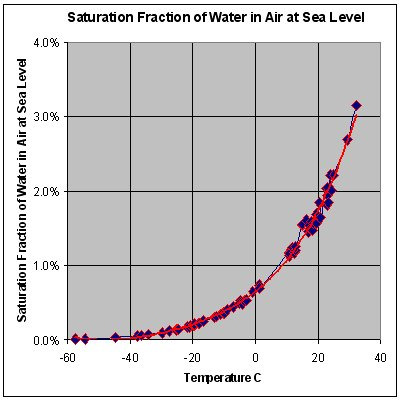

In [5]:
# copy raw data into a df to be cleaned
weather_df = weather_df_raw.copy()

In [6]:
# Printing all the unique values of null columns
# verifying snow, wpgt & tsun seem to be empty columns,
print([weather_df['snow'].unique(),
    weather_df['wpgt'].unique(),
    weather_df['tsun'].unique()])

[array([nan]), array([nan]), array([nan])]


In [7]:
# removed ols with no information (variance)
weather_df = weather_df.drop(['snow', 'wpgt', 'tsun'], axis=1)
print(weather_df.columns)

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco'], dtype='object')


In [8]:
# properly format dates into datetime objs
weather_df['time'] = pd.to_datetime(weather_df['time'], infer_datetime_format=True)

In [9]:
# verify there are no time gaps in the data's rows
# Sort the DataFrame by the 'time' column
weather_df = weather_df.sort_values(by='time')

# Calculate the time difference between consecutive rows
time_diffs = weather_df['time'].diff()
print(time_diffs.value_counts())

0 days 01:00:00    8784
Name: time, dtype: int64


In [10]:
start_date = weather_df['time'].min()
end_date = weather_df['time'].max()
print( "start_date: ", start_date)
print( "end_date: ", end_date)

start_date:  2022-10-21 00:00:00
end_date:  2023-10-22 00:00:00


In [11]:
# verify wspd, wdir should be both be 0 together
# print the other's value when one of these were 0
print(weather_df[weather_df['wspd']==0]['wdir'].unique())
print(weather_df[weather_df['wdir']==0]['wspd'].unique())

[0.]
[0.]


## Create a clearer Weather Condition column
Remapping the coco column to their respecitive [weather condition code](https://dev.meteostat.net/formats.html#weather-condition-codes) description.

In [12]:
weather_df['coco'].unique()

array([ 3.,  1.,  2.,  7.,  8.,  9.,  5., 17., 14., 15., 12., 21., 18.,
       13.])

In [13]:
# convert coco col to it's proper type
weather_df['coco'] = weather_df['coco'].astype('int64')
weather_df['coco'].unique()

array([ 3,  1,  2,  7,  8,  9,  5, 17, 14, 15, 12, 21, 18, 13])

In [14]:
# Code	Weather Condition
coco_map = {
    1: "Clear",
    2: "Fair",
    3: "Cloudy",
    4: "Overcast",
    5: "Fog",
    6: "Freezing Fog",
    7: "Light Rain",
    8: "Rain",
    9: "Heavy Rain",
    10: "Freezing Rain",
    11: "Heavy Freezing Rain",
    12: "Sleet",
    13: "Heavy Sleet",
    14: "Light Snowfall",
    15: "Snowfall",
    16: "Heavy Snowfall",
    17: "Rain Shower",
    18: "Heavy Rain Shower",
    19: "Sleet Shower",
    20: "Heavy Sleet Shower",
    21: "Snow Shower",
    22: "Heavy Snow Shower",
    23: "Lightning",
    24: "Hail",
    25: "Thunderstorm",
    26: "Heavy Thunderstorm",
    27: "Storm"
}

weather_df['weather'] = weather_df['coco'].replace(coco_map)
weather_df['weather'].unique()

array(['Cloudy', 'Clear', 'Fair', 'Light Rain', 'Rain', 'Heavy Rain',
       'Fog', 'Rain Shower', 'Light Snowfall', 'Snowfall', 'Sleet',
       'Snow Shower', 'Heavy Rain Shower', 'Heavy Sleet'], dtype=object)

In [15]:
weather_df.head()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,weather
0,2022-10-21 00:00:00,13.0,1.1,44.0,0.0,190.0,7.6,1008.0,3,Cloudy
1,2022-10-21 01:00:00,10.7,1.0,51.0,0.0,160.0,7.6,1008.0,3,Cloudy
2,2022-10-21 02:00:00,9.0,1.5,59.0,0.0,180.0,5.4,1008.0,3,Cloudy
3,2022-10-21 03:00:00,9.0,1.5,59.0,0.0,180.0,5.4,1008.0,3,Cloudy
4,2022-10-21 04:00:00,7.6,1.5,65.0,0.0,170.0,5.4,1008.0,1,Clear


## Verifying coco weather descriptions are consistent
* "Light Rain" < "Rain" < "Heavy Rain" < "Heavy Rain Shower"
* "Light Snowfall" < "Snowfall"

In [16]:
# Create a pivot table for minimum and maximum precipitation 'prcp' values for each category in 'weather'
filtered_weather_df = weather_df[weather_df['weather'].str.contains('Rain|Snow')]
weather_pivot = filtered_weather_df.pivot_table(index='weather', values='prcp', aggfunc={'prcp': ['min', 'max']})
print(weather_pivot)

                    max  min
weather                     
Heavy Rain         16.4  0.3
Heavy Rain Shower   8.9  0.3
Light Rain          7.1  0.1
Light Snowfall      0.3  0.1
Rain               26.2  0.2
Rain Shower        10.7  0.1
Snow Shower         0.2  0.2
Snowfall            1.0  0.3


## coco weather quality descriptions are NOT consistent

In [17]:
weather_df = weather_df.drop(['weather', 'coco'], axis='columns')
weather_df.head()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres
0,2022-10-21 00:00:00,13.0,1.1,44.0,0.0,190.0,7.6,1008.0
1,2022-10-21 01:00:00,10.7,1.0,51.0,0.0,160.0,7.6,1008.0
2,2022-10-21 02:00:00,9.0,1.5,59.0,0.0,180.0,5.4,1008.0
3,2022-10-21 03:00:00,9.0,1.5,59.0,0.0,180.0,5.4,1008.0
4,2022-10-21 04:00:00,7.6,1.5,65.0,0.0,170.0,5.4,1008.0


In [20]:
weather_df.set_index('time', inplace=True)
weather_df.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2022-10-21 00:00:00,13.0,1.1,44.0,0.0,190.0,7.6,1008.0
2022-10-21 01:00:00,10.7,1.0,51.0,0.0,160.0,7.6,1008.0
2022-10-21 02:00:00,9.0,1.5,59.0,0.0,180.0,5.4,1008.0
2022-10-21 03:00:00,9.0,1.5,59.0,0.0,180.0,5.4,1008.0
2022-10-21 04:00:00,7.6,1.5,65.0,0.0,170.0,5.4,1008.0


In [21]:
# Output cleaned data to a csv
insert_i = 7
file_path_clean = directory_path + "/clean_" + file_path[insert_i:]
print(file_path_clean)
weather_df.to_csv(file_path_clean)

./data/clean_weather_10-21-2022_to_10-22-2023.csv
